<img src="https://www.kaunokolegija.lt/kk_wp_content/uploads/sites/5/2020/05/kaunas-university-of-applied-sciences.png" width="300"/> 

------

# Recurrent Neural Networks

A case study of univariate time series analysis.

### Practical Session

<br/> Prof. Dr. Georgios K. Ouzounis
<br/> email: georgios.ouzounis@go.kauko.lt
<br/>last update: June 25, 2021


--------

## Contents

1. [Challenge](#challenge)
2. [Download the data](#download-the-data)
3. [Visualize the stock price history](#visualize-the-stock-price-history)
4. [Data transforms and preprocessing](#data-transforms-and-preprocessing)
5. [Build the RNN](#build-the-rnn)
6. [Train the RNN](#train-the-rnn)
7. [Improve the RNN](#improve-the-rnn)
8. [Fine tune the RNN](#fine-tune-the-rnn)

## Challenge <a name="challenge"></a>

<img src="https://miro.medium.com/max/3504/1*NpT5pyemQQsGEHXbfS51Zw.png" width="600" align="left"/>


Given a 5-year history of any stock traded in NASDAQ predict the stock prices for the period of the recent-most month that are not included in the historical data.

To address this challenge we will employ [**univariate time series analysis**](www.homepages.ucl.ac.uk/~uctpsc0/Teaching/GR03/TS1.pdf) with [**recurrent neural networks**](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks).

## Download the data  <a name="download-the-data"></a>

In [1]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# install yahoo-finance
!pip install yfinance

     |████████████████████████████████| 6.3MB 4.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=ddfd7ba71a7c756240aa311f76fe746e992aa59bdf95a9c75e1a8b713d64da5b
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
# copy some custom code files 
!wget https://raw.githubusercontent.com/georgiosouzounis/deep-learning-lectures/main/code/NASDAQ_io.py

--2021-07-03 12:29:53--  https://raw.githubusercontent.com/georgiosouzounis/deep-learning-lectures/main/code/NASDAQ_io.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1716 (1.7K) [text/plain]
Saving to: ‘NASDAQ_io.py’

NASDAQ_io.py        100%[===================>]   1.68K  --.-KB/s    in 0s      

2021-07-03 12:29:53 (27.7 MB/s) - ‘NASDAQ_io.py’ saved [1716/1716]



In [5]:
# import necessary functions
from NASDAQ_io import * #getStockTickerSymbols, searchBySymbol, getStockPriceHistory, getDateTime

In [6]:
# get the companies listed in NASDAQ
companies = getStockTickerSymbols()

In [7]:
# view the companies
companies

,Symbol,Company Name,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size
0,AAIT,iShares MSCI All Country Asia Information Tech...,iShares MSCI All Country Asia Information Tech...,G,N,N,100.0
1,AAL,"American Airlines Group, Inc.","American Airlines Group, Inc. - Common Stock",Q,N,N,100.0
2,AAME,Atlantic American Corporation,Atlantic American Corporation - Common Stock,G,N,N,100.0
3,AAOI,"Applied Optoelectronics, Inc.","Applied Optoelectronics, Inc. - Common Stock",G,N,N,100.0
4,AAON,"AAON, Inc.","AAON, Inc. - Common Stock",Q,N,N,100.0
...,...,...,...,...,...,...,...
2962,ZN,Zion Oil & Gas Inc,Zion Oil & Gas Inc - Common Stock,G,N,N,100.0
2963,ZNGA,Zynga Inc.,Zynga Inc. - Class A Common Stock,Q,N,N,100.0
2964,ZSPH,"ZS Pharma, Inc.","ZS Pharma, Inc. - Common Stock",G,N,N,100.0
2965,ZU,"zulily, inc.","zulily, inc. - Class A Common Stock",Q,N,N,100.0


In [8]:
# Let us go for Tesla
symbol = 'TSLA'

In [9]:
# check if the symbol exists; if it doesn't the dataframe will be empty
df = searchBySymbol(companies, symbol)

In [10]:
# set the strat and end date for our training data
start_date = getDateTime(2016,1,1)
end_date = getDateTime(2021,5,31)

In [11]:
# get the stock history
stock_history = getStockPriceHistory(df, start_date, end_date)

0 : TSLA,

In [12]:
# view the contents of the dataframe
stock_history

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2016-01-04,46.144001,46.276001,43.799999,44.681999,44.681999,34135500,TSLA
2016-01-05,45.271999,45.377998,44.000000,44.686001,44.686001,15934000,TSLA
2016-01-06,44.000000,44.009998,43.195999,43.807999,43.807999,18895500,TSLA
2016-01-07,42.838001,43.688000,42.734001,43.130001,43.130001,17771500,TSLA
2016-01-08,43.571999,44.088001,42.153999,42.200001,42.200001,18140500,TSLA
...,...,...,...,...,...,...,...
2021-05-24,581.599976,614.479980,573.650024,606.440002,606.440002,34558100,TSLA
2021-05-25,607.309998,613.989990,595.710022,604.690002,604.690002,28005900,TSLA
2021-05-26,607.559998,626.169983,601.500000,619.130005,619.130005,28639300,TSLA


### a quick visualization example

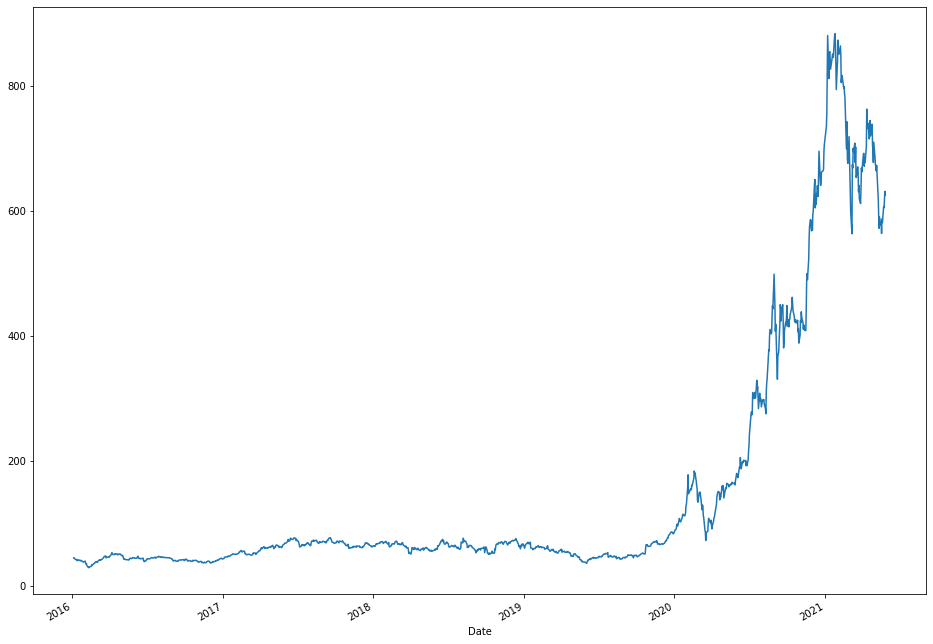

In [13]:
# let us plot a quick chart to see the history of the stock in the timeframe specified  
stock_history['Close'].plot(figsize=(16, 12))

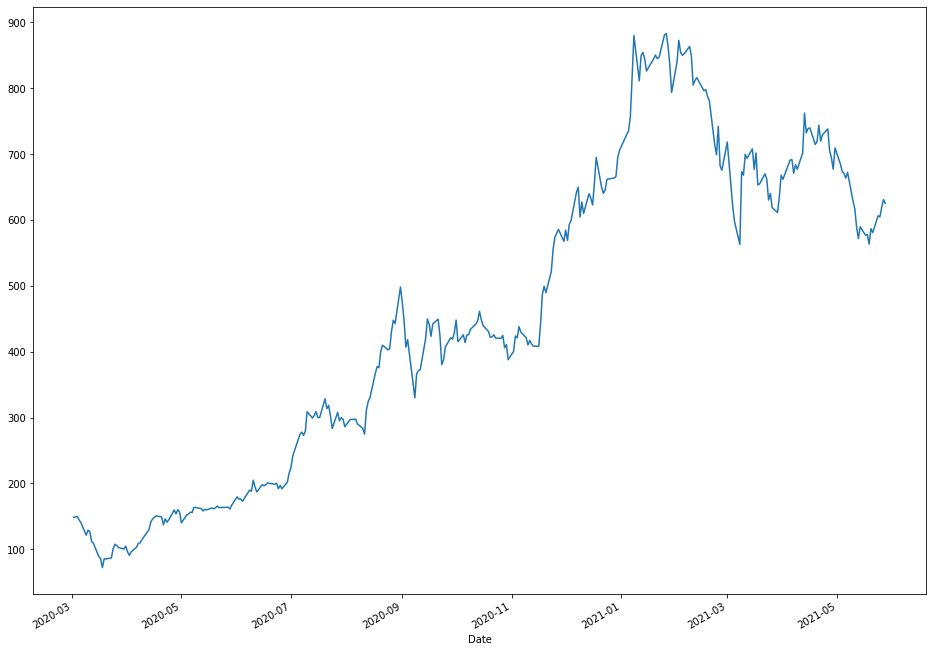

In [14]:
# use truncate() to zoom into a specific date range
stock_history.truncate(before='2020-03-01')['Close'].plot(figsize=(16, 12))

In [15]:
# The Date is set as the dataframe index. This is not very elegant!
# Use the reset_index() function to make this the first column in 
# your dataframe and reset the index
stock_history.reset_index(inplace=True)

In [16]:
# confirm the change
stock_history

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2016-01-04,46.144001,46.276001,43.799999,44.681999,44.681999,34135500,TSLA
1,2016-01-05,45.271999,45.377998,44.000000,44.686001,44.686001,15934000,TSLA
2,2016-01-06,44.000000,44.009998,43.195999,43.807999,43.807999,18895500,TSLA
3,2016-01-07,42.838001,43.688000,42.734001,43.130001,43.130001,17771500,TSLA
4,2016-01-08,43.571999,44.088001,42.153999,42.200001,42.200001,18140500,TSLA
...,...,...,...,...,...,...,...,...
1356,2021-05-24,581.599976,614.479980,573.650024,606.440002,606.440002,34558100,TSLA
1357,2021-05-25,607.309998,613.989990,595.710022,604.690002,604.690002,28005900,TSLA
1358,2021-05-26,607.559998,626.169983,601.500000,619.130005,619.130005,28639300,TSLA
1359,2021-05-27,620.239990,631.130005,616.210022,630.849976,630.849976,26370600,TSLA


## Visualize the stock price history <a name="visualize-the-stock-price-history"></a>

The visualization code is a modified version of the original, preseneted by [Trifunovic Uros](https://trifunovic-uros.medium.com/) in [Medium.com](https://medium.com/analytics-vidhya/visualizing-historical-stock-price-and-volume-from-scratch-46029b2c5ef9) on Mar. 23, 2021.

Start by getting a copy of the code in  the local path

In [17]:
!wget https://raw.githubusercontent.com/georgiosouzounis/deep-learning-lectures/main/code/stock_price_chart.py

--2021-07-03 12:30:25--  https://raw.githubusercontent.com/georgiosouzounis/deep-learning-lectures/main/code/stock_price_chart.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2623 (2.6K) [text/plain]
Saving to: ‘stock_price_chart.py’

stock_price_chart.p 100%[===================>]   2.56K  --.-KB/s    in 0s      

2021-07-03 12:30:25 (45.0 MB/s) - ‘stock_price_chart.py’ saved [2623/2623]



In [18]:
# import the get_charts() function
from stock_price_chart import get_charts

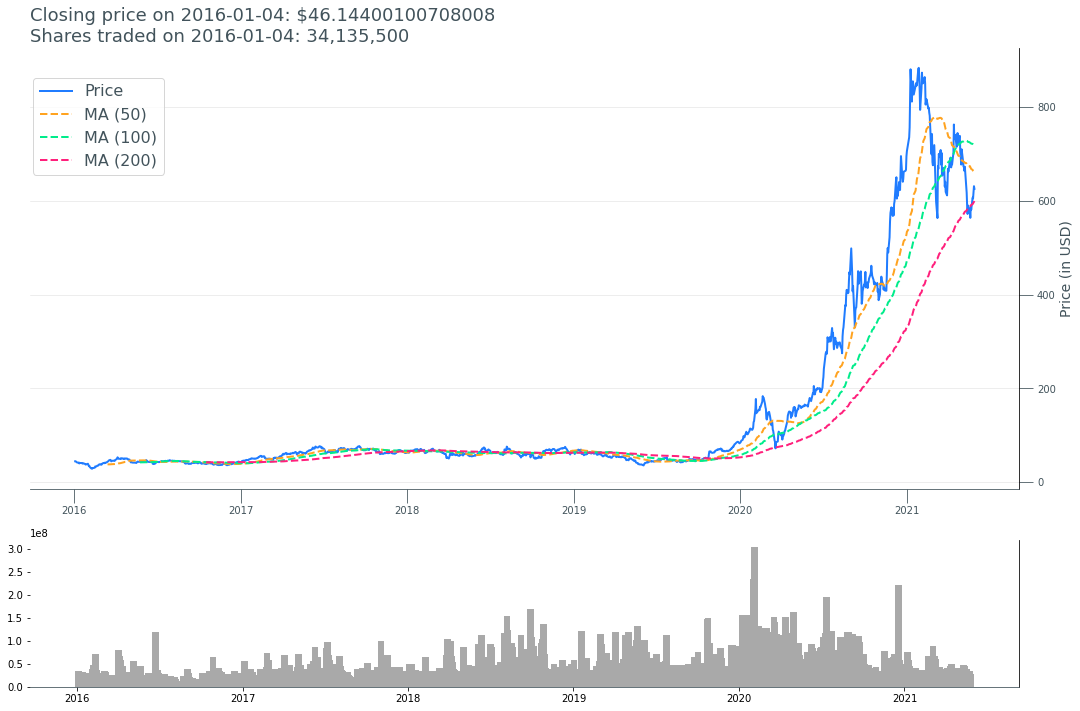

In [19]:
# plot the contents of our dataframe
get_charts(stock_history)

## Data transforms and preprocessing <a name="data-transforms-and-preprocessing"></a>

Next we need to tidy-up our data and  transform it according to the needs of our
project
###  Data clean-up

In [20]:
# extract the relevant data, i.e. `Open` values
# the .values makes this a vector numpy array
training_set = stock_history.iloc[:, 1:2].values 

In [21]:
training_set

array([[ 46.14400101],
       [ 45.27199936],
       [ 44.        ],
       ...,
       [607.55999756],
       [620.23999023],
       [628.5       ]])

### Feature Scaling

Next we need to rescale our data to the range from 0.0 to 1.0. 

Feature scaling is essential as discussed if the Features lecture and needs to be applied to both the training and test sets.

It is computed using the ScikitLearn library [MinMaxScaler()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) which transforms the selected feature by scaling it to a given range. If more than one, this estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

In [22]:
# import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [23]:
# create a scaler instance to rescale all data to the range of 0.0 to 1.0 
sc = MinMaxScaler(feature_range = (0, 1))

In [24]:
# create the actual training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [25]:
# confirm feature scaling
training_set_scaled

array([[0.02048867],
       [0.01947814],
       [0.01800407],
       ...,
       [0.67109196],
       [0.68578632],
       [0.69535852]])

### Splitting the training set to dependent and independent variables

The stock prices are stored in a 2D numpy array containing a single column of data.

From this array we need to define our feature vectors. Each feature vector starts with the stock price a day later compared to its predecessor. It is of fixed length, i.e it consists of a fixed number of consecutive stock prices. The stock price after the last one inserted in each feature vector can be considered as our dependent variable, i.e. the N stock prices before today can be used to predict today's price. N is the number of timesteps.

<img src="https://drive.google.com/uc?id=1bckuLGZCeLUzNA-xJCGOODzC-4n2U-If"/>

In [26]:
# define the number of timesteps
timesteps = 60 # 60 stock prices or 3 months worth of data assuming 20 working days a month

# each row is to contain the last 60 stock prices before the reference date
X_train = [] 

# each entry (this is a 1D vector) is to contain teh stock price at the reference date
y_train = []

In [27]:
training_set_scaled.shape

(1361, 1)

In [28]:
# we start from day 60 because that is the first instance allowing us to 
# go back 60 days; first day is 0
for i in range(timesteps, training_set_scaled.shape[0]): 
    # 0 is the column ID, the only column in this case.    
    # put the last 60 days values in one row of X_train
    X_train.append(training_set_scaled[i-60:i, 0]) 
    y_train.append(training_set_scaled[i, 0])

In [29]:
# convert these to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [30]:
# the X_train 2D numpy array has 60 rows less compared to the original dataset
X_train.shape

(1301, 60)

### Reshaping the Matrix

We need to add a new matrix dimension to accommodate the indicator (predictor). 

NumPy matrices are tensors (3D) and essentially we need to specify that our matrix consists of **60 days** (dimension x) times **total days in data set** (dimension y) times **1 value per matrix cell (scalar)** (dimension z). If we were to include the value of a different stock with the the past 60 days of Tesla, we would need to change the length of the 3d dimension to 2. RNN training tables are 3D!!! Read: [Reshaping NumPy Array | Numpy Array Reshape Examples](https://backtobazics.com/python/python-reshaping-numpy-array-examples/)

In [31]:
# Reshaping the data matrix, we retain the 2 original dimensions and add a third of depth=1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Build the RNN <a name="build-the-rnn"></a>

### RNN initialization

- Import the sequential model from the Keras API;
- Import the Dense layer template from the Keras API;
- Import the LSTM model from the Keras API
- Create an instance of the sequential model called regressor because we want to predict a continuous value

In [32]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [33]:
# Initialising the RNN as a sequence of layers
regressor = Sequential()

### Add First Layer

We first add an object of the LSTM class! 

- The first argument is the number of units or LSTM memory cells. Include many neurons to address the high dimensionality of the problem; say 50 neurons! 
- Second arg: return sequences = true; stacked LSTM !
- Third arg: input 3D shape: observations vs time steps vs number of indicators

In [34]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [35]:
# the argument is the dropout rate to ignore in the layers (20%), 
# i.e. 50 units * 20% = 10 units will be dropped each time
regressor.add(Dropout(0.2))

### Add More Layers

We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

We don’t need to add the shape of the layer again because it is recognized automatically from the number of input units.

The last layer does not return a sequence but connected directly to a fully connected output layer.

In [36]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [37]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [38]:
# Adding a fourth LSTM layer and some Dropout regularisation
# we removed the return_sequences because we no longer return a 
# sequence but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Add Output Layer & Compile

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [39]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [40]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

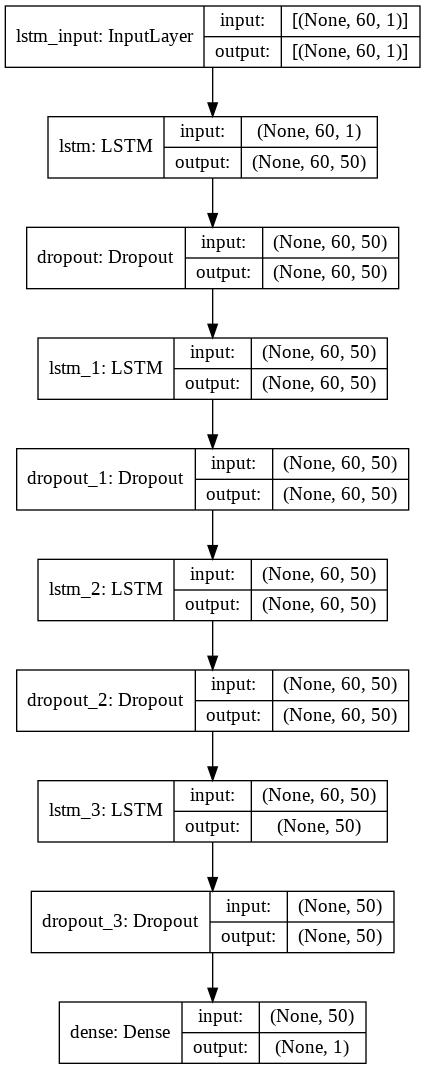

In [41]:
# review the network architecture
from keras.utils.vis_utils import plot_model
plot_model(regressor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train the RNN <a name="train-the-rnn"></a>

### Fit the RNN to the Training set

We now want to train our RNN using the data in our **Training Set X** and **predictors in y** (ground truth in this case). Parameters that can be specified are the:

- **Batch size**:  update the cell weights not on every stock price on every batch_size values; 
- **Number of epochs**: how many iterations to be used, i.e. number of forward and backward propagations for the update of the weights

In [42]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
41/41 [==============================] - 28s 118ms/step - loss: 0.0299
Epoch 2/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0031
Epoch 3/100
41/41 [==============================] - 5s 120ms/step - loss: 0.0020
Epoch 4/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0022
Epoch 5/100
41/41 [==============================] - 5s 119ms/step - loss: 0.0026
Epoch 6/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0025
Epoch 7/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0027
Epoch 8/100
41/41 [==============================] - 5s 118ms/step - loss: 0.0032
Epoch 9/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0021
Epoch 10/100
41/41 [==============================] - 5s 116ms/step - loss: 0.0018
Epoch 11/100
41/41 [==============================] - 5s 113ms/step - loss: 0.0021
Epoch 12/100
41/41 [==============================] - 5s 115ms/step - loss: 0.0016
Epoch 13/100

## Deploy the RNN <a name="deploy-the-rnn"></a>

### Computing Predictions

Get the test set in a new dataframe. That will be one month of stock prices after the end of the preior used for training.

There are 20 (19 to 21) financial days in one month, weekends excluded!

In [43]:
# Getting the real stock price

# first set the date range (make sure it does not overlap with our training data period)
start_date = getDateTime(2021,6,1)
end_date = getDateTime(2021,6,30)

In [44]:
# get the relevant stock proce history
dataset_test = getStockPriceHistory(df, start_date, end_date)
dataset_test.reset_index(inplace=True)

0 : TSLA,

In [45]:
# extract the relevant columns 
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

21

In [46]:
# verify your data
real_stock_price

array([[627.79998779],
       [620.13000488],
       [601.79998779],
       [579.71002197],
       [591.83001709],
       [623.01000977],
       [602.16998291],
       [603.88000488],
       [610.22998047],
       [612.22998047],
       [616.69000244],
       [597.53997803],
       [601.89001465],
       [613.36999512],
       [624.47998047],
       [618.25      ],
       [632.        ],
       [674.98999023],
       [689.58001709],
       [671.64001465],
       [684.65002441]])

To predict the stock price value for each day in this date range, we need the values in the last 60 days.

To obtain this **history** we need to combine both the training and test sets in one.

If we were to use the training_set and test_set we would need to use the scaler but that would change the actual test values. Thus concatenate the original data frames!

In [47]:
# axis = 0 means concatenate the lines (i.e. vertical axis)
dataset_total = pd.concat((stock_history['Open'], dataset_test['Open']), axis = 0)

In [48]:
dataset_total.size

1382

In [49]:
# the difference in the length of the first two gives us 
# the first day in the new date range, and we need to go back 60 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values

In [50]:
inputs.size

81

In [51]:
# we did not use iloc from panda so lets reshape the numpy array for 
# compatibility: i.e. all the values from input lines to be stacked in one 
# column. The -1 means that the numpy has no knowledge of how the 
# values were stored in lines. The 1 means we want to them in one 
# column.

inputs = inputs.reshape(-1,1) 

# apply the feature scaler
inputs = sc.transform(inputs)

1. For each price in test date range we need the **immediate 60 values** before it. 
2. We have 21 prices in June;
3. We need a numpy 3D array of 60 prices (columns) times 21 days (rows) times 1 dependent variable 
4. We don’t need y_test. That is what we are trying to compute!

In [52]:
# Getting the predicted stock price of 2017
X_test = []

In [54]:
# the first 60 from inputs are from training set; start 
# from 60 and get the extra 21, i.e. up to 81
for i in range(timesteps, inputs.size): 
    X_test.append(inputs[i-timesteps:i, 0])

In [55]:
X_test = np.array(X_test) # not 3D structure yet

In [56]:
# create a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [57]:
# source this input to our regressor model
predicted_stock_price = regressor.predict(X_test)

In [58]:
# need to inverse the scaling to get meaningful predicted stock price # outputs
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

21

### Result Visualization

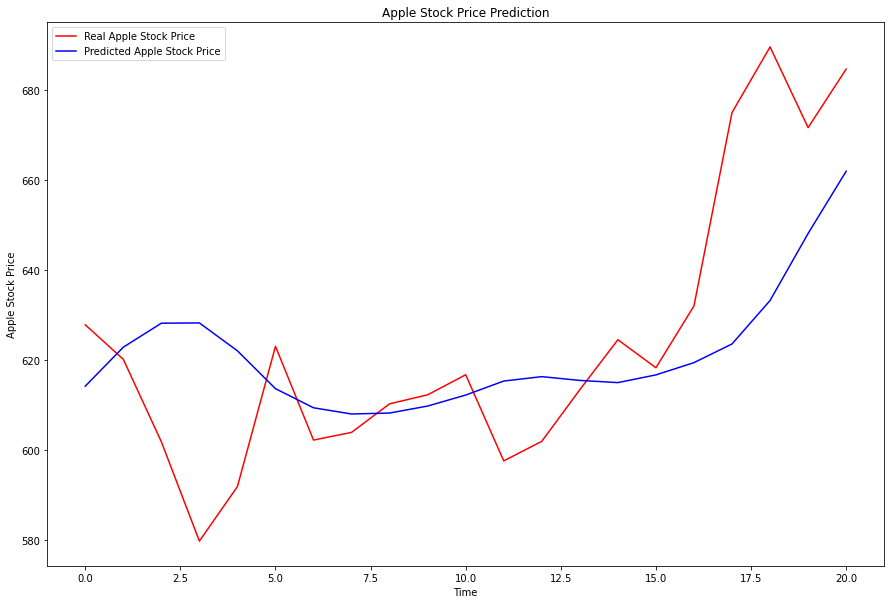

In [59]:
# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()

plt.show()

The blue line shows the trend of the stock for the month of January 2017.

Some observations:

- The prediction lags behind the actual price curve because the model cannot react to fast non-linear changes. Spikes are examples of fast non-linear changes
- Model reacts pretty well to smooth changes



### Compute the RMSE

If we need to compute the RMSE for our Stock Price Prediction problem, we use the real stock price and predicted stock price as shown.

Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 to get a relative error, as opposed to an absolute error. 

In [60]:
#import the libraries
import math
from sklearn.metrics import mean_squared_error

In [61]:
rmse = math.sqrt( mean_squared_error( real_stock_price[0:21,:], predicted_stock_price))
rmse

23.917950598911876

## Improve the RNN <a name="improve-the-rnn"></a>

The new data need to be placed in the same order/format  as in the case of the training/test sets.

1. Getting more training data: we trained our model on the past 5 years of the  Google Stock Price but it would be even better to train it on the past 10 years.

2. Increasing the number of time steps: the model remembered the stock price from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 time steps (3 months). You could try to increase the number of time steps, by choosing for example 120 time steps (6 months).

3. Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

4. Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

5. Adding more neurons in the LSTM layers: we highlighted the fact that we needed a high number of neurons in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurons in each of our 4 LSTM layers. You could try an architecture with even more neurons in each of the 4 (or more) LSTM layers.

## Fine tune the RNN  <a name="fine-tune-the-rnn"></a>

Parameter Tuning on the RNN model: we are dealing with a Regression problem because we predict a continuous outcome.

Tip: replace: scoring = 'accuracy' by scoring = 'neg_mean_squared_error' in the GridSearchCV class parameters as we did in the ANN case.